## Generating Synthetic Seismogram in Python

Authors: Hyunmin Kim, Honggeun Jo | Modified from [Ryan A. Mardani](https://www.linkedin.com/in/amardani/)

In [2]:
## In case you haven't installed the followings:
# !pip install pyvista
# !pip install trame
# !pip install --upgrade trame-vuetify
# !pip install --upgrade trame-vtk
# !pip install ipywidgets

In [19]:
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from tqdm import tqdm

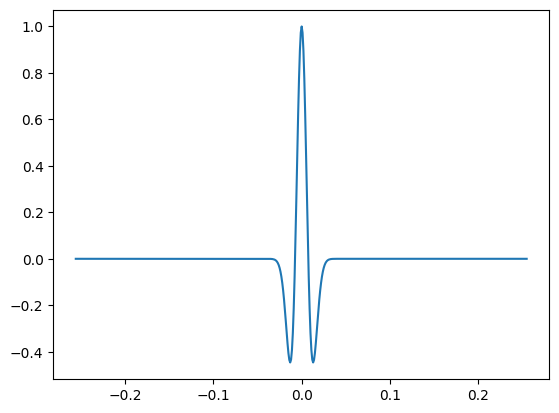

In [29]:
# step 0 - top depth and v_above given + other inputs
NX, NY, NZ = 128, 128, 100
tops = np.ones((NY, NX)) * 1500 # <- random input, meter flat horizon 
v_above = 1500                  # <- random input, m/s 
DZ = np.ones((NZ, NY, NX))/2      

# time domain variables
dt = 0.001   #sampleing interval
t_max = 3.0   # max time to create time vector
t = np.arange(0, t_max, dt)

# define Ricker wavelet
def ricker(f, length, dt):
    t0 = np.arange(-length/2, (length-dt)/2, dt)
    y = (1.0 - 2.0*(np.pi**2)*(f**2)*(t0**2)) * np.exp(-(np.pi**2)*(f**2)*(t0**2))
    return t0, y
f=30            # wavelet frequency
length=0.512    # wavelet vector length
dt=dt           # sampling prefer to use smiliar to resampled AI
t0, w = ricker(f, length, dt) # ricker wavelet 

plt.plot(t0, w)

In [30]:
# step 1 - import Vp and Rho_b, which will be imported from CMG runs
# saturation (composition), pressure, porosity (static/updated)
# TODO: convert S, P, Poro to Vp and Rho_b

Vp = np.random.uniform(1500, 2500, size = (NZ, NY, NX))
Rho_b = np.random.uniform(800, 1500, size = (NZ, NY, NX))

assert Rho_b.min() > 0 and Vp.min() > 0, "unrealistic input"

In [31]:
# step 2 - compute AI and TWT
AI = Vp * Rho_b
TWT = -np.ones_like(AI)
for i in tqdm(range(NX)):
    for j in range(NY):
        for k in range(NZ):
            TWT[k, j, i] = 2*((tops[j,i]/v_above) + (DZ[:k+1, j, i]/Vp[:k+1, j, i]).sum())

assert TWT.min() > 0, 'negative TWT is detected'

100%|██████████| 128/128 [00:09<00:00, 13.09it/s]


In [32]:
# step 3 - resample AI in time domain
AI_tdom = -np.ones((t.shape[0], NY, NX))
for i in range(NX):
    for j in range(NY):
       AI_tdom[:, j, i] = np.interp(x=t, xp=TWT[:,j,i], fp = AI[:,j,i])

assert AI_tdom.min() > 0, 'negative AI is detected'

In [33]:
# step 4 - compute reflectivity in time domain
Rc_tdom = -np.ones_like(AI_tdom)
Rc_tdom[:-1] = (AI_tdom[1:]-AI_tdom[:-1])/(AI_tdom[1:]+AI_tdom[:-1]) 
Rc_tdom[-1] = Rc_tdom[-2]


In [34]:
# step 5 - convolve with the AI in time domain
seismic_tdom = -100*np.ones_like(AI_tdom)
for i in range(NX):
    for j in range(NY):
        seismic_tdom[:, j, i] = np.convolve(w, Rc_tdom[:, j, i], mode='same')

assert seismic_tdom.min() > -5 and seismic_tdom.max() < 5 , 'erroneous seismic is detected, seismic should be oscillated around zero'

In [35]:
# visualization 
seismic_tdom_cut = seismic_tdom[(t>TWT.min())&(t<TWT.max())]

grid = pv.ImageData()
grid.dimensions = np.array(seismic_tdom_cut[::-1].T.shape) + 1
grid.origin = (1, 1, 1)  # The bottom left corner of the data set
grid.spacing = (1, 1, 1)  # These are the cell sizes along each axis
grid.cell_data["values"] = seismic_tdom_cut[::-1].T.flatten(order="F")  # Flatten the array

grid.plot(show_edges=False, cmap = 'seismic')

Widget(value="<iframe src='http://localhost:60168/index.html?ui=P_0x1eabb9ba990_7&reconnect=auto' style='width…

In [36]:
# step 6 - resample seismic in depth domain
seismic = -np.ones_like(AI)
for i in range(NX):
    for j in range(NY):
        seismic[:, j, i] = np.interp(x=TWT[:, j, i], xp = t, fp = seismic_tdom[:, j, i])

In [ ]:
# visualization 
grid = pv.ImageData()
grid.dimensions = np.array(seismic[::-1].T.shape) + 1
grid.origin = (1, 1, 1)  # The bottom left corner of the data set
grid.spacing = (1, 1, 1/3)  # These are the cell sizes along each axis
grid.cell_data["values"] = seismic[::-1].T.flatten(order="F")  # Flatten the array

grid.plot(show_edges=False, cmap = 'seismic')

Widget(value="<iframe src='http://localhost:60168/index.html?ui=P_0x1eaa0730b10_8&reconnect=auto' style='width…

Exception raised
ConnectionResetError('Cannot write to closing transport')
Traceback (most recent call last):
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\wslink\protocol.py", line 340, in onMessage
    await self.sendWrappedMessage(
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\wslink\protocol.py", line 484, in sendWrappedMessage
    await ws.send_str(encMsg)
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\aiohttp\web_ws.py", line 336, in send_str
    await self._writer.send(data, binary=False, compress=compress)
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\aiohttp\http_websocket.py", line 729, in send
    await self._send_frame(message, WSMsgType.TEXT, compress)
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\aiohttp\http_websocket.py", line 682, in _send_frame
    self._write(header + message)
  File "c:\Users\DELL\Ap

In [10]:
## TODO: Refer to https://docs.pyvista.org/version/stable/examples/00-load/terrain-mesh#sphx-glr-examples-00-load-terrain-mesh-py

### Refrences:<br>
[Agile geoscience and SEG WiKI](https://wiki.seg.org/wiki/Well_tie_calculus)